In [1]:
import pandas as pd
from pathlib import Path
import os
import csv
import glob
import shutil
from collections import Counter
import numpy as np
import tensorflow as tf
import keras
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
import matplotlib.pyplot as plt
import seaborn as sb
import cv2
from scipy import ndimage
import sklearn
from random import shuffle
from keras.layers import *
from keras.models import Model, load_model
import tensorflow.keras.backend as K
from tensorflow import losses, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from scipy.ndimage import shift
from scipy.ndimage import map_coordinates
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, classification_report
from itertools import chain
from scipy.ndimage import gaussian_filter
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight

2025-01-09 13:04:20.359525: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-09 13:04:20.387329: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-09 13:04:20.405167: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-09 13:04:20.410158: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-09 13:04:20.424645: I tensorflow/core/platform/cpu_feature_guar

In [3]:
# gpus = tf.config.list_physical_devices('GPU')
# if gpus:
#   try:
#     # Currently, memory growth needs to be the same across GPUs
#     for gpu in gpus:
#       tf.config.experimental.set_memory_growth(gpu, True)
#     logical_gpus = tf.config.list_logical_devices('GPU')
#     print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
#   except RuntimeError as e:
#     # Memory growth must be set before GPUs have been initialized
#     print(e)

In [7]:
# Image size for resizing
image_size = (128, 128)  # Adjust based on your preference or model requirements

# Function to load images and labels
def load_data(folder):
    images = []
    labels = []
    class_names = sorted(os.listdir(folder))  # Sort to ensure consistent label ordering
    class_to_label = {class_name: idx for idx, class_name in enumerate(class_names)}
    
    for class_name in class_names:
        class_folder = os.path.join(folder, class_name)
        if not os.path.isdir(class_folder):
            continue
        for image_name in tqdm(os.listdir(class_folder)):
            image_path = os.path.join(class_folder, image_name)
            try:
                # Read and resize image
                image = cv2.imread(image_path)
                if image is not None:
                    image = cv2.resize(image, image_size)
                    images.append(image)
                    labels.append(class_to_label[class_name])
            except Exception as e:
                print(f"Error loading image {image_path}: {e}")
    
    return np.array(images), np.array(labels), class_to_label

# Load the dataset
x_train, y_train, class_mapping_train = load_data(r'/mnt/c/Users/Dhruba/Data/Blood cell dataset/Raabin WBC/Train')
x_test, y_test, class_mapping_test = load_data(r'/mnt/c/Users/Dhruba/Data/Blood cell dataset/Raabin WBC/Test')

# Normalize images (optional, recommended for deep learning)
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Print dataset details
print(f"x_training data shape: {x_train.shape} and test data shape: {x_test.shape}: ")
print(f"x_training label shape: {y_train.shape} and test label shape: {y_test.shape}: ")
print(f"Class mapping: {class_mapping_train}")

# y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)

print("Train label shape:", y_train.shape)
print("Test encoded label shape:", y_test_encoded.shape)

100%|███████████████████████████████████████████████████████████████████████████████| 4631/4631 [03:12<00:00, 24.07it/s]


x_training data shape: (10175, 128, 128, 3) and test data shape: (6458, 128, 128, 3): 
x_training label shape: (10175,) and test label shape: (6458,): 
Class mapping: {'Basophil': 0, 'Eosinophil': 1, 'Lymphocyte': 2, 'Monocyte': 3, 'Neutrophil': 4}
Train label shape: (10175,)
Test encoded label shape: (6458, 5)


In [11]:
# np.save('/mnt/c/Users/Dhruba/Data/Blood cell dataset/Raabin WBC/Test/test_data.npy', x_test)
# np.save('/mnt/c/Users/Dhruba/Data/Blood cell dataset/Raabin WBC/Test/test_label_enc.npy', y_test_encoded)
# np.save('/mnt/c/Users/Dhruba/Data/Blood cell dataset/Raabin WBC/Train/train_data.npy', x_train)
# np.save('/mnt/c/Users/Dhruba/Data/Blood cell dataset/Raabin WBC/Train/train_label.npy', y_train)

In [2]:
## for train and test with 90:10 ratio analysis load them ##
x_test = np.load('/mnt/c/Users/Dhruba/Data/Blood cell dataset/Raabin WBC/Test/test_data.npy')
y_test_encoded = np.load('/mnt/c/Users/Dhruba/Data/Blood cell dataset/Raabin WBC/Test/test_label_enc.npy')
# x_train = np.load('/mnt/c/Users/Dhruba/Data/Blood cell dataset/Raabin WBC/Train/train_data.npy')
# y_train = np.load('/mnt/c/Users/Dhruba/Data/Blood cell dataset/Raabin WBC/Train/train_label.npy')

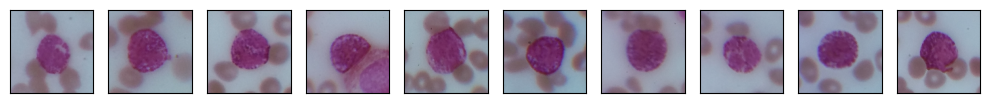

In [12]:
plt.figure(figsize=(10,5))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.grid(False)
    plt.imshow((x_train[i] * 255).astype(np.uint8))
plt.show()

In [13]:
## Perform horizontal and vertical flips
x_train_hflip = np.flip(x_train[0:212], axis=2)  # Horizontal flip (flip along width)
y_train_hflip = y_train[0:212]
x_train_vflip = np.flip(x_train[0:212], axis=1)  # Vertical flip (flip along height)
y_train_vflip = y_train[0:212]

## Combine original and augmented data
x_train_augmented = np.concatenate((x_train, x_train_hflip, x_train_vflip), axis=0)
y_train_augmented = np.concatenate((y_train, y_train_hflip, y_train_vflip), axis=0)

# Check the shapes for confirmation
print("Original dataset shape:", x_train.shape)
print("Augmented dataset shape:", x_train_augmented.shape)
print("Augmented label shape:", y_train_augmented.shape)

Original dataset shape: (10175, 128, 128, 3)
Augmented dataset shape: (10599, 128, 128, 3)
Augmented label shape: (10599,)


In [14]:
del x_train_hflip
del x_train_vflip

In [15]:
def translate_image(image, shift_x, shift_y):
    """
    Translate the image by shift_x and shift_y.
    Uses constant fill for pixels outside boundaries.
    """
    return shift(image, shift=(shift_y, shift_x, 0), mode='constant', cval=0.0)

# Create translated datasets
x_train_translated_pos = np.array([translate_image(img, 20, 20) for img in tqdm(x_train[0:956])])  # +10 pixels in both directions
y_train_tpos = y_train[0:956]
x_train_translated_neg = np.array([translate_image(img, -20, -20) for img in tqdm(x_train[0:956])])  # -10 pixels in both directions
y_train_tneg = y_train[0:956]

# Combine original and translated data
x_train_augmented = np.concatenate((x_train_augmented, x_train_translated_pos, x_train_translated_neg), axis=0)
y_train_augmented = np.concatenate((y_train_augmented, y_train_tpos, y_train_tneg), axis=0)

# Check the shapes for confirmation
print("Original dataset shape:", x_train.shape)
print("Augmented dataset shape:", x_train_augmented.shape)
print("Augmented label shape:", y_train_augmented.shape)

100%|█████████████████████████████████████████████████████████████████████████████████| 956/956 [00:14<00:00, 64.21it/s]


Original dataset shape: (10175, 128, 128, 3)
Augmented dataset shape: (12511, 128, 128, 3)
Augmented label shape: (12511,)


In [16]:
del x_train_translated_pos
del x_train_translated_neg

In [18]:
def scale_image(image, scale_factor):
    """
    Scale the image by a given scale factor.
    """
    h, w = image.shape[:2]
    new_h, new_w = int(h * scale_factor), int(w * scale_factor)
    scaled_image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_LINEAR)

    # Crop or pad the image back to the original size
    if scale_factor > 1:
        # Crop center
        start_h = (new_h - h) // 2
        start_w = (new_w - w) // 2
        return scaled_image[start_h:start_h + h, start_w:start_w + w]
    else:
        # Pad with zeros
        pad_h = (h - new_h) // 2
        pad_w = (w - new_w) // 2
        return np.pad(
            scaled_image,
            ((pad_h, h - new_h - pad_h), (pad_w, w - new_w - pad_w), (0, 0)),
            mode='constant',
            constant_values=0
        )

# Apply scaling
x_train_scaled_up = np.array([scale_image(img, 1.10) for img in tqdm(x_train[3383:3944])])  # +2% scaling
y_train_scaled_up = y_train[3383:3944]
x_train_scaled_down = np.array([scale_image(img, 0.90) for img in tqdm(x_train[3383:3944])])  # -2% scaling
y_train_scaled_down = y_train[3383:3944]

# Combine original and scaled datasets
x_train_augmented = np.concatenate((x_train_augmented, x_train_scaled_up, x_train_scaled_down), axis=0)
y_train_augmented = np.concatenate((y_train_augmented, y_train_scaled_up, y_train_scaled_down), axis=0)

# Check the shapes for confirmation
print("Original dataset shape:", x_train.shape)
print("Augmented dataset shape:", x_train_augmented.shape)
print("Augmented label shape:", y_train_augmented.shape)

100%|███████████████████████████████████████████████████████████████████████████████| 561/561 [00:00<00:00, 9350.94it/s]


Original dataset shape: (10175, 128, 128, 3)
Augmented dataset shape: (13633, 128, 128, 3)
Augmented label shape: (13633,)


In [19]:
del x_train_scaled_up
del x_train_scaled_down

In [26]:
def elastic_transform_2d(image, alpha, sigma=8, random_state=None):

    if random_state is None:
        random_state = np.random.RandomState(None)
    #print(random_state)
    shape = image.shape
    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    x, y, z = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]), np.arange(shape[2]))
    indices = np.reshape(y+dy, (-1, 1)), np.reshape(x+dx, (-1, 1)), np.reshape(z, (-1, 1))
    distored_image = map_coordinates(image, indices, order=1, mode='reflect')  #wrap,reflect, nearest
    return distored_image.reshape(image.shape)

img_aug_array=[]
label_array = []
alphas = [1000, 800]
for d in tqdm(range(3383, 3944)):
    for e in range (2):
            volume = elastic_transform_2d(x_train[d], alpha=alphas[e])
            img_aug_array.append(volume)
            label = y_train[d]
            label_array.append(label)
        
x_aug_et = np.array(img_aug_array, np.float32)
#x_train_augmented = np.concatenate((x_train_augmented, x_aug_et), axis=0)
y_aug = np.array(label_array, np.float32)
#y_train_augmented = np.concatenate((y_train_augmented, y_aug), axis=0)
print("Original dataset shape:", x_train.shape)
print("Augmented dataset shape:", x_train_augmented.shape)
print("Augmented labelshape:", y_train_augmented.shape)

100%|█████████████████████████████████████████████████████████████████████████████████| 561/561 [00:15<00:00, 36.27it/s]

Original dataset shape: (10175, 128, 128, 3)
Augmented dataset shape: (14755, 128, 128, 3)
Augmented labelshape: (14755,)


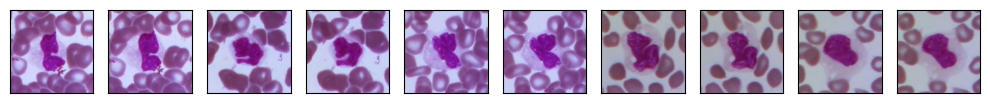

In [27]:
plt.figure(figsize=(10,5))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.grid(False)
    plt.imshow((x_aug_et[i] * 255).astype(np.uint8))
plt.show()

In [28]:
del x_aug_et

In [24]:
y_train_encoded = to_categorical(y_train_augmented)
y_train_encoded.shape

In [5]:
def dense_block(x, repetitions, filters):
    for _ in range(repetitions):
        y = BatchNormalization()(x)
        y = ReLU()(y)
        y = Conv2D(4 * filters, 1, padding='same')(y)
        y = BatchNormalization()(y)
        y = ReLU()(y)
        y = Conv2D(filters, 3, padding='same')(y)
        x = concatenate([y, x])
    return x

def transition_layer(x):
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(K.int_shape(x)[-1] // 2, 1, padding='same')(x)
    x = AvgPool2D(2, strides=2, padding='same')(x)
    return x

def DenseNet121(input_shape=(128, 128, 3), num_classes=5):
    inputs = Input(input_shape)

    x = Conv2D(64, 7, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPool2D(3, strides=2, padding='same')(x)
    x = Dropout(0.1)(x)
    
    x = dense_block(x, 6, 32)
    x = transition_layer(x)
    x = Dropout(0.1)(x)

    x = dense_block(x, 12, 32)
    x = transition_layer(x)
    x = Dropout(0.1)(x)
    
    x = dense_block(x, 24, 32)
    x = transition_layer(x)
    x = Dropout(0.1)(x)

    x = dense_block(x, 16, 32)
    x = Dropout(0.1)(x)

    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.1)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

model = DenseNet121()
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_360 (Conv2D) │ (None, 64, 64,    │      9,472 │ input_layer_3[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_360[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_360 (ReLU)    │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 32, 32,    │          0 │ re_lu_360[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_18          │ (None, 32, 32,    │          0 │ max_pooling2d_3[… │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ dropout_18[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_361 (ReLU)    │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_361 (Conv2D) │ (None, 32, 32,    │      8,320 │ re_lu_361[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_361[0][0]  │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_362 (ReLU)    │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_362 (Conv2D) │ (None, 32, 32,    │     36,896 │ re_lu_362[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_174     │ (None, 32, 32,    │          0 │ conv2d_362[0][0], │
│ (Concatenate)       │ 96)               │            │ dropout_18[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        384 │ concatenate_174[… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_363 (ReLU)    │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_363 (Conv2D) │ (None, 32, 32,    │     12,416 │ re_lu_363[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_363[0][0]

 Total params: 7,048,773 (26.89 MB)

 Trainable params: 6,967,173 (26.58 MB)

 Non-trainable params: 81,600 (318.75 KB)

In [41]:
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip((y_true) * (y_pred), 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives/(possible_positives + K.epsilon())
    
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1))) 
    return true_negatives / (possible_negatives + K.epsilon())

def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer._decayed_lr(tf.float32) # I use ._decayed_lr method instead of .lr
    return lr
    
LR = 0.001
lr_schedule = optimizers.schedules.ExponentialDecay(
    initial_learning_rate=LR,
    decay_steps=10000,
    decay_rate=0.1) #should be < 1, otherwise lr rate increases

optim = optimizers.Adam(learning_rate=lr_schedule)
lr_metric = get_lr_metric(optim)


model.compile(optimizer=optim, loss = 'categorical_crossentropy', metrics=['accuracy'])  ##if not one-hot encoded use: SparseCategoricalCrossentropy

In [42]:
filepath = '/mnt/c/Users/Dhruba/Codes/saved models/WBC_raab_wght_dns.ep{epoch:02d}-test_acc_{val_accuracy:.3f}.keras'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_accuracy',
                             verbose=1, 
                             save_best_only=True,
                             mode='max')

y_train_int = np.argmax(y_train_encoded, axis=1)
## Calculate class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_int),
    y=y_train_int
)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

print("Class Weights:", class_weights_dict)

result = model.fit(x=x_train_augmented,
                    y=y_train_encoded,
                    batch_size = 40,
                    epochs = 11,
                    verbose = 1,
                    validation_data = (x_test, y_test_encoded),
                    callbacks=[checkpoint],
                    class_weight=class_weights_dict,### results in poor accuracy 
                    shuffle=True)

Class Weights: {0: 2.7839622641509436, 1: 1.3221326164874552, 2: 1.215904408735064, 3: 1.0520499108734402, 4: 0.4735997432193869}
Epoch 1/11


2024-12-03 16:41:07.209101: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'input_compare_reduce_fusion_56', 8 bytes spill stores, 8 bytes spill loads



368/369 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.6777 - loss: 1.1291

2024-12-03 16:42:43.505332: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'input_compare_reduce_fusion_50', 8 bytes spill stores, 8 bytes spill loads



369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - accuracy: 0.6781 - loss: 1.1278
Epoch 1: val_accuracy improved from -inf to 0.08129, saving model to /mnt/c/Users/Dhruba/Codes/saved models/WBC_raab_wght_dns.ep01-test_acc_0.081.keras
369/369 ━━━━━━━━━━━━━━━━━━━━ 226s 306ms/step - accuracy: 0.6784 - loss: 1.1265 - val_accuracy: 0.0813 - val_loss: 14.8541
Epoch 2/11
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9026 - loss: 0.2832
Epoch 2: val_accuracy improved from 0.08129 to 0.57572, saving model to /mnt/c/Users/Dhruba/Codes/saved models/WBC_raab_wght_dns.ep02-test_acc_0.576.keras
369/369 ━━━━━━━━━━━━━━━━━━━━ 36s 96ms/step - accuracy: 0.9026 - loss: 0.2830 - val_accuracy: 0.5757 - val_loss: 1.6136
Epoch 3/11
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9435 - loss: 0.1553
Epoch 3: val_accuracy improved from 0.57572 to 0.58826, saving model to /mnt/c/Users/Dhruba/Codes/saved models/WBC_raab_wght_dns.ep03-test_acc_0.588.keras
369/369 ━━━━━━━━━━━━━━━━━━━━ 34s 92ms/step - a

In [3]:
best_model = load_model('/mnt/c/Users/Dhruba/Codes/saved models/WBC_fd5_dns.v_acc_0.857-loss_1.019.keras', compile = True)
#best_model.summary()

I0000 00:00:1733333700.544618    2285 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:47:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1733333700.803980    2285 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:47:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1733333700.804137    2285 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:47:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1733333700.822187    2285 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:47:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1733333700.822354    2285 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:47:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

In [34]:
best_model.evaluate(x_test, y_test_encoded, batch_size=40, verbose=1)

162/162 ━━━━━━━━━━━━━━━━━━━━ 13s 39ms/step - accuracy: 0.5681 - loss: 10.7389


[3.9528555870056152, 0.8033446669578552]

In [5]:
y_pred = best_model.predict(x_test, batch_size=40,  verbose=0)

sparse_gt = np.argmax(y_test_encoded, axis=1)
sparse_pred = np.argmax(y_pred, axis=1)

### Calculate accuracy
accuracy = accuracy_score(sparse_gt, sparse_pred)
#print("Accuracy:", accuracy)

cm = confusion_matrix(sparse_gt, sparse_pred)
# Calculate macro-averaged AUC
macro_auc = roc_auc_score(sparse_gt, y_pred, multi_class="ovr", average="macro") 
# Calculate micro-averaged AUC
micro_auc = roc_auc_score(sparse_gt, y_pred, multi_class="ovr", average="micro") 

print("Accuracy of model on full test data: ", accuracy)
print("Macro-averaged AUC on full test data: ", macro_auc)
print("Micro-averaged AUC on full test data: ", micro_auc)
# # Calculate precision, recall, and F1-score for each class
# precision = precision_score(y, sparse_pred, average=None)
# recall = recall_score(y, sparse_pred, average=None)
# f1 = f1_score(y, sparse_pred, average=None)

# # Calculate macro, micro, and weighted scores
# macro_f1 = f1_score(y, sparse_pred, average='macro')
# micro_f1 = f1_score(y, sparse_pred, average='micro')
# weighted_f1 = f1_score(y, sparse_pred, average='weighted')

Accuracy of model on full test data:  0.8569216475689068
Macro-averaged AUC on full test data:  0.9834144935056829
Micro-averaged AUC on full test data:  0.9758822815234843


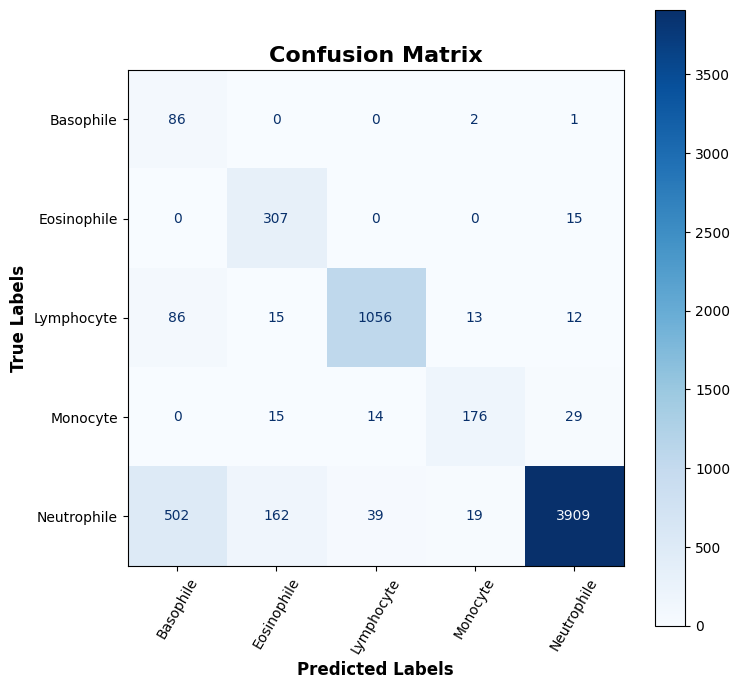

In [6]:
class_names = ['Basophile', 'Eosinophile', 'Lymphocyte', 'Monocyte', 'Neutrophile']
plt.figure(figsize=(8, 8))
# Create ConfusionMatrixDisplay object
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

## Plot the confusion matrix
disp.plot(cmap=plt.cm.Blues, ax=plt.gca(), colorbar=True)
## Rotate x-axis labels
plt.xticks(rotation=60)

# Customize the title and axis labels
plt.title("Confusion Matrix", fontsize=16, fontweight='bold')
plt.xlabel("Predicted Labels", fontsize=12, fontweight='bold')
plt.ylabel("True Labels", fontsize=12, fontweight='bold')

#plt.tight_layout()
plt.show()

In [9]:
# Print classification report
report = classification_report(sparse_gt, sparse_pred, target_names=[f"Class {i}" for i in range(5)])
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

     Class 0       0.13      0.97      0.23        89
     Class 1       0.62      0.95      0.75       322
     Class 2       0.95      0.89      0.92      1182
     Class 3       0.84      0.75      0.79       234
     Class 4       0.99      0.84      0.91      4631

    accuracy                           0.86      6458
   macro avg       0.70      0.88      0.72      6458
weighted avg       0.94      0.86      0.89      6458



In [ ]:
# Specify the folder containing the .keras files
folder_path = "/mnt/c/Users/Dhruba/Codes/saved models"
split_num = 40

# Use glob to find all .keras files in the folder
keras_files = glob.glob(os.path.join(folder_path, "*.keras"))
# Iterate through each file
for file_path in keras_files:
    print(file_path)
    best_model = load_model(file_path, compile = True)
    accuracy_list = []
    CM = []
    mac_auc = []
    mic_auc = [] 
    Y = []
    Pred = []
    for i in tqdm(range(split_num)):  
        x = splits[i][0]
        y = splits[i][1]
        
        y_pred = best_model.predict(x, batch_size=40,  verbose=0)
        sparse_pred = np.argmax(y_pred, axis=1)
        
        ### Calculate accuracy
        accuracy = accuracy_score(y, sparse_pred)
        #print("Accuracy:", accuracy)
        accuracy_list.append(accuracy)
    
        cm = confusion_matrix(y, sparse_pred)
        CM.append(cm)
    
        # Calculate macro-averaged AUC
        macro_auc = roc_auc_score(y, y_pred, multi_class="ovr", average="macro") 
        mac_auc.append(macro_auc)
        # Calculate micro-averaged AUC
        micro_auc = roc_auc_score(y, y_pred, multi_class="ovr", average="micro") 
        mic_auc.append(micro_auc)
       
        Y.append(y)
        Pred.append(sparse_pred)
    total_acc = sum(accuracy_list[:split_num])/split_num
    print("Accuracy of model on full test data: ", total_acc)
    
    macro_auc = sum(mac_auc[:split_num])/split_num
    print("Macro-averaged AUC on full test data: ", macro_auc)
    
    micro_auc = sum(mic_auc[:split_num])/split_num
    print("Micro-averaged AUC on full test data: ", micro_auc)

/mnt/c/Users/Dhruba/Codes/saved models/WBC_f1_cbam_dns.ep01-test_acc_0.76.keras


  0%|                                                                                            | 0/40 [00:00<?, ?it/s]2024-11-28 20:07:21.845709: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5699', 4 bytes spill stores, 4 bytes spill loads

2024-11-28 20:07:22.348130: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5699', 172 bytes spill stores, 172 bytes spill loads

2024-11-28 20:07:36.995885: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5699', 4 bytes spill stores, 4 bytes spill loads

2024-11-28 20:07:37.263698: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusio

Accuracy of model on full test data:  0.7165193305919668
Macro-averaged AUC on full test data:  0.9679336189353684
Micro-averaged AUC on full test data:  0.9771281610993425
/mnt/c/Users/Dhruba/Codes/saved models/WBC_f1_cbam_dns.ep02-test_acc_0.88.keras


100%|███████████████████████████████████████████████████████████████████████████████████| 40/40 [01:22<00:00,  2.05s/it]


Accuracy of model on full test data:  0.5077875342052265
Macro-averaged AUC on full test data:  0.9593947121267306
Micro-averaged AUC on full test data:  0.9458869186446602
/mnt/c/Users/Dhruba/Codes/saved models/WBC_f1_cbam_dns.ep03-test_acc_0.95.keras


100%|███████████████████████████████████████████████████████████████████████████████████| 40/40 [01:23<00:00,  2.08s/it]


Accuracy of model on full test data:  0.7783282829594882
Macro-averaged AUC on full test data:  0.9824697065533057
Micro-averaged AUC on full test data:  0.9859810229024205
/mnt/c/Users/Dhruba/Codes/saved models/WBC_f1_cbam_dns.ep04-test_acc_0.98.keras


100%|███████████████████████████████████████████████████████████████████████████████████| 40/40 [01:23<00:00,  2.09s/it]


Accuracy of model on full test data:  0.838250133604501
Macro-averaged AUC on full test data:  0.9804139383481016
Micro-averaged AUC on full test data:  0.9915077628826312
/mnt/c/Users/Dhruba/Codes/saved models/WBC_f1_cbam_dns.ep05-test_acc_0.99.keras


100%|███████████████████████████████████████████████████████████████████████████████████| 40/40 [01:31<00:00,  2.28s/it]


Accuracy of model on full test data:  0.8500299991587864
Macro-averaged AUC on full test data:  0.9825798427482537
Micro-averaged AUC on full test data:  0.9918700602902666
/mnt/c/Users/Dhruba/Codes/saved models/WBC_f1_cbam_dns.ep06-test_acc_1.00.keras


100%|███████████████████████████████████████████████████████████████████████████████████| 40/40 [01:18<00:00,  1.97s/it]


Accuracy of model on full test data:  0.860766852723305
Macro-averaged AUC on full test data:  0.9837745392753418
Micro-averaged AUC on full test data:  0.992458239788049
/mnt/c/Users/Dhruba/Codes/saved models/WBC_f1_cbam_dns.ep07-test_acc_1.00.keras


100%|███████████████████████████████████████████████████████████████████████████████████| 40/40 [01:28<00:00,  2.21s/it]


Accuracy of model on full test data:  0.8524679101781889
Macro-averaged AUC on full test data:  0.9829126854295508
Micro-averaged AUC on full test data:  0.9925181505094953
/mnt/c/Users/Dhruba/Codes/saved models/WBC_f1_cbam_dns.ep08-test_acc_1.00.keras


100%|███████████████████████████████████████████████████████████████████████████████████| 40/40 [01:28<00:00,  2.21s/it]


Accuracy of model on full test data:  0.8583085608321086
Macro-averaged AUC on full test data:  0.9844072445706098
Micro-averaged AUC on full test data:  0.9916866558248495
/mnt/c/Users/Dhruba/Codes/saved models/WBC_f1_cbam_dns.ep09-test_acc_1.00.keras


100%|███████████████████████████████████████████████████████████████████████████████████| 40/40 [01:28<00:00,  2.22s/it]


Accuracy of model on full test data:  0.8645230876000178
Macro-averaged AUC on full test data:  0.9853557705429392
Micro-averaged AUC on full test data:  0.9925690551341748
/mnt/c/Users/Dhruba/Codes/saved models/WBC_f1_cbam_dns.ep10-test_acc_1.00.keras


100%|███████████████████████████████████████████████████████████████████████████████████| 40/40 [01:29<00:00,  2.23s/it]


Accuracy of model on full test data:  0.864797750001237
Macro-averaged AUC on full test data:  0.9822542936725809
Micro-averaged AUC on full test data:  0.9923295920728128
/mnt/c/Users/Dhruba/Codes/saved models/WBC_f1_cbam_dns.ep11-test_acc_1.00.keras


100%|███████████████████████████████████████████████████████████████████████████████████| 40/40 [01:24<00:00,  2.12s/it]


Accuracy of model on full test data:  0.8669413754583376
Macro-averaged AUC on full test data:  0.9843251024335853
Micro-averaged AUC on full test data:  0.9921080740925335
/mnt/c/Users/Dhruba/Codes/saved models/WBC_f1_cbam_dns.ep12-test_acc_1.00.keras


100%|███████████████████████████████████████████████████████████████████████████████████| 40/40 [01:33<00:00,  2.33s/it]


Accuracy of model on full test data:  0.8670006160651991
Macro-averaged AUC on full test data:  0.9840054785832724
Micro-averaged AUC on full test data:  0.9921830222212277
/mnt/c/Users/Dhruba/Codes/saved models/WBC_f1_cbam_dns.ep13-test_acc_1.00.keras


 40%|█████████████████████████████████▏                                                 | 16/40 [00:55<00:48,  2.02s/it]